# Assignment 5
The goal is to test a pre-trained Faster R-CNN on some picture from the coco dataset.
Follow these steps:
1. Download the file „2017 Val images [5/1GB]“ and „ 2017 Train/Val annotations [241MB]“ from
the Coco page. You can use the library pycocotools to load them into your notebook.
2. Randomly select 10 images from this dataset.
3. Use a pre-trained version of Faster R-CNN (Resnet50 backbone) to predict the bounding box
of objects on the 10 images. Only keep regions that have a score > 0.8.
4. Visualize the predicted bounding boxes and label together with the ground truth bounding
boxes and label. Show all 10 pairs of images side by side in the jupyter notebook.
5. Repeat the steps from above using a Mobilenet backbone for the Faster R-CNN.
6. Wich backbone delivers the better results? Calculate the IoU for both approaches.

In [22]:

# CNN 
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

# others
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import time
import random

# torchvision
import torchvision
import torchvision.transforms as transforms

# dataset 
from pycocotools.coco import COCO
import cv2


cudnn.benchmark = True
plt.ion()   # interactive mode

# Task 1 
1. Download the file „2017 Val images [5/1GB]“ and „ 2017 Train/Val annotations [241MB]“ from
the Coco page. You can use the library pycocotools to load them into your notebook.

In [23]:
cocoRoot = "../../Data/Coco/"
dataType = "val2017"

annFile = os.path.join(cocoRoot, f'annotations/instances_{dataType}.json')
print(f'Annotation file: {annFile}')

Annotation file: ../../Data/Coco/annotations/instances_val2017.json


In [24]:
# # initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


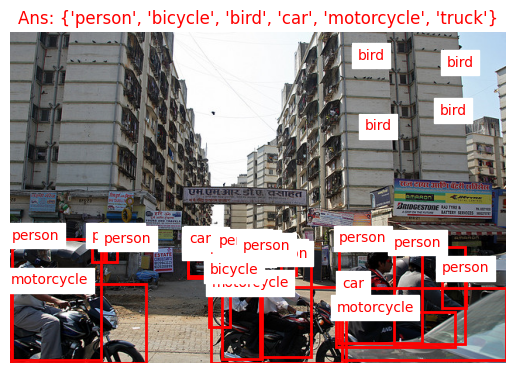

In [67]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_image_with_annotations(coco, cocoRoot, dataType, imgId, ax=None):
    imgInfo = coco.loadImgs(imgId)[0]
    imPath = os.path.join(cocoRoot, dataType, imgInfo['file_name'])    
    im = cv2.imread(imPath)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # 加入 bounding boxes 和 labels
    annIds = coco.getAnnIds(imgIds=imgInfo['id'])
    anns = coco.loadAnns(annIds)
    all_labels = set()

    # bbox 
    for ann in anns:
        x, y, w, h = ann['bbox']

        # label 
        label = coco.loadCats(ann['category_id'])[0]["name"]
        all_labels.add(label)

        # draw bbox
        rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    
        # draw label
        if ax is None:
            plt.gca().add_patch(rect) 
            plt.text(x, y, f'{label}', fontsize=10, color='r', backgroundcolor='w')
        else:
            ax.add_patch(rect)
            ax.text(x, y, f'{label}', fontsize=10, color='r', backgroundcolor='w' )

    if ax is None:
        plt.imshow(im)
        plt.axis('off')
        plt.title(f'Ans: {all_labels}', color='r')
        plt.show()
    else:
        ax.axis('off')
        ax.set_title(f'Ans: {all_labels}', color='r',loc='center', pad=20)
        ax.imshow(im)

# 使用範例
imgIds = coco.getImgIds()
imgId = imgIds[10]
plot_image_with_annotations(coco, cocoRoot, dataType, imgId)


# Task 2
2. Randomly select 10 images from this dataset.

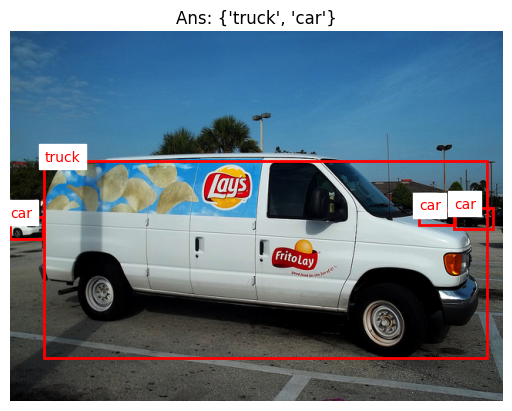

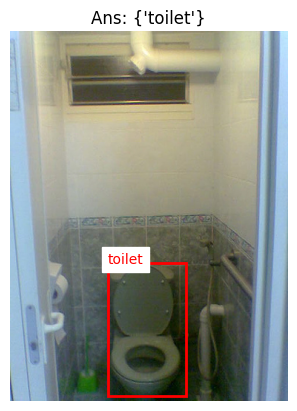

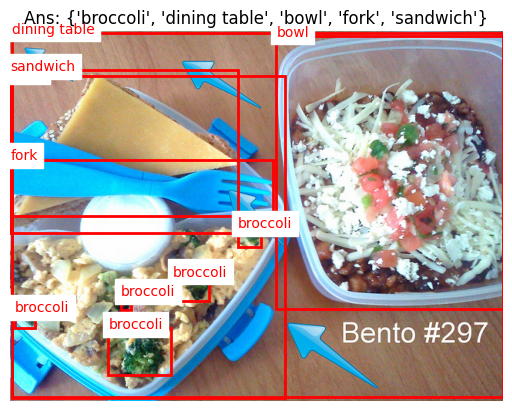

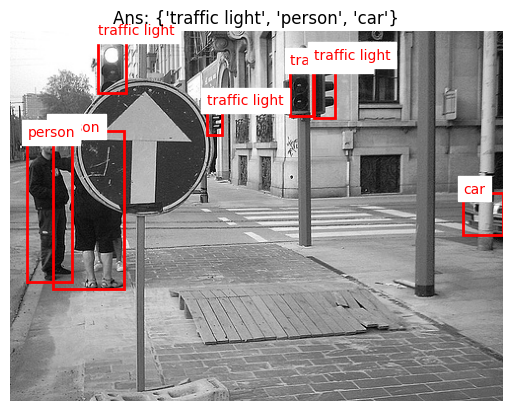

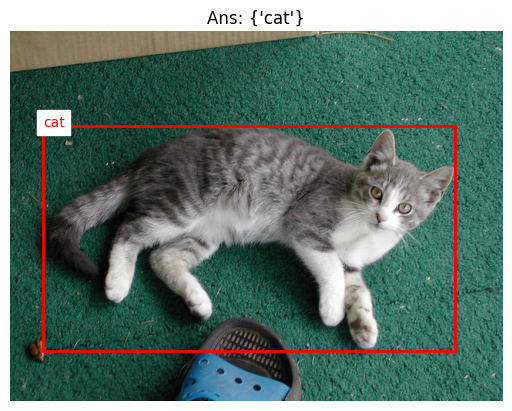

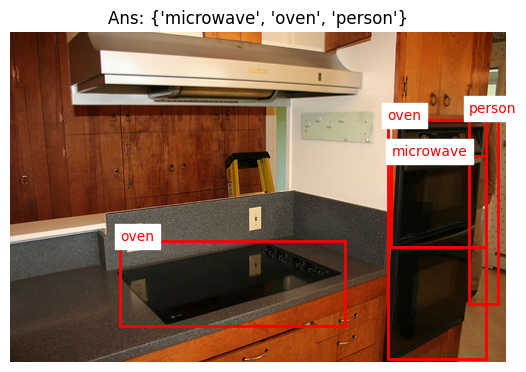

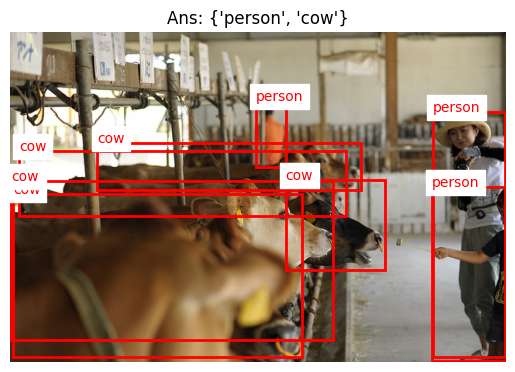

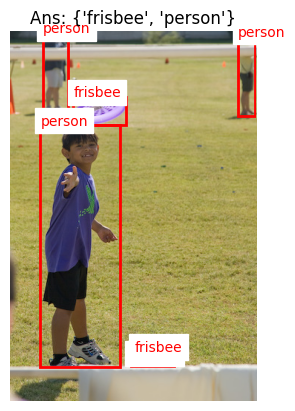

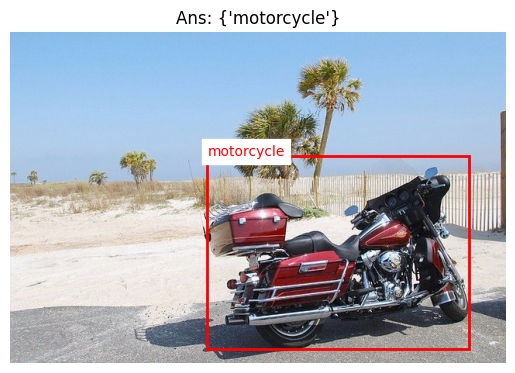

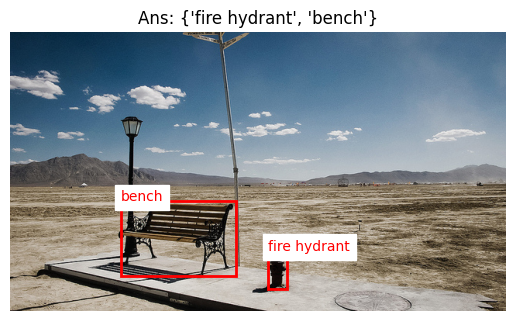

[196759, 180792, 369771, 505942, 186296, 508312, 258911, 261036, 18737, 372203]

In [37]:
def random_select(coco, cocoRoot, dataType, num_images=10):
    imgIds = coco.getImgIds()
    selected_imgIds = random.sample(imgIds, num_images)
    for imgId in selected_imgIds:
        plot_image_with_annotations(coco, cocoRoot, dataType, imgId)
    return selected_imgIds
    
valid_ids = random_select(coco, cocoRoot, dataType, num_images=10)
valid_ids

# Task 3 & 5 
3. Use a pre-trained version of Faster R-CNN (Resnet50 backbone) to predict the bounding box
of objects on the 10 images. Only keep regions that have a score > 0.8.
5. Repeat the steps from above using a Mobilenet backbone for the Faster R-CNN.

In [28]:
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model_res = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
model_res.eval()

model_mobile = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights)
model_mobile.eval()

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [29]:
def load_image(imgIdx):
    imgInfo = coco.loadImgs(imgIdx)[0]
    imPath = os.path.join(cocoRoot, dataType, imgInfo['file_name'])    
    print(imPath)
    try:
        return Image.open(imPath)
    except:
        raise Exception()

def pil2tensor(pil_image):
    return torchvision.transforms.PILToTensor()(pil_image).unsqueeze(0) / 255.0

In [38]:
predictions_res = []
predictions_mobile = []
for i in valid_ids:
    print(i)
    img_as_tensor = pil2tensor(load_image(i))
    prediction = model_res(img_as_tensor)
    predictions_res.append(prediction)

    prediction = model_mobile(img_as_tensor)
    predictions_mobile.append(prediction)



196759
../../Data/Coco/val2017/000000196759.jpg
180792
../../Data/Coco/val2017/000000180792.jpg
369771
../../Data/Coco/val2017/000000369771.jpg
505942
../../Data/Coco/val2017/000000505942.jpg
186296
../../Data/Coco/val2017/000000186296.jpg
508312
../../Data/Coco/val2017/000000508312.jpg
258911
../../Data/Coco/val2017/000000258911.jpg
261036
../../Data/Coco/val2017/000000261036.jpg
18737
../../Data/Coco/val2017/000000018737.jpg
372203
../../Data/Coco/val2017/000000372203.jpg


In [39]:
def filter_valid_boxes(predictions, threshold=0.8):
    valid_boxes_list = []

    for prediction in predictions:
        valid_boxes_for_this_prediction = []
        for box, label, score in zip(prediction[0]["boxes"], prediction[0]["labels"], prediction[0]["scores"]):
            if score >= threshold:
                valid_boxes_for_this_prediction.append((box, label, score))
        valid_boxes_list.append(valid_boxes_for_this_prediction)

    return valid_boxes_list

# Example usage:
valid_boxes_res = filter_valid_boxes(predictions_res, threshold=0.8)
valid_boxes_mobile = filter_valid_boxes(predictions_mobile, threshold=0.8)


In [40]:
print("len(valid_boxes_res):", len(valid_boxes_res))
print("len(valid_boxes_mobile):", len(valid_boxes_mobile))

len(valid_boxes_res): 10
len(valid_boxes_mobile): 10


# Task 4 & 6 
4. Visualize the predicted bounding boxes and label together with the ground truth bounding
boxes and label. Show all 10 pairs of images side by side in the jupyter notebook.
6. Wich backbone delivers the better results? Calculate the IoU for both approaches.

ResNet: Avg. 0.75097907 ; each IoU: [0.85810316, 0.8798218, 0.7873156, 0.537568, 0.877316, 0.34706074, 0.69576, 0.76523274, 0.8608233, 0.90078974]
MobileNet: Avg. 0.67789185 ; each IoU: [0.65745175, 0.8976369, 0.56265527, 0.44600075, 0.96300954, 0.3595999, 0.75358695, 0.7570977, 0.9110173, 0.47086272]


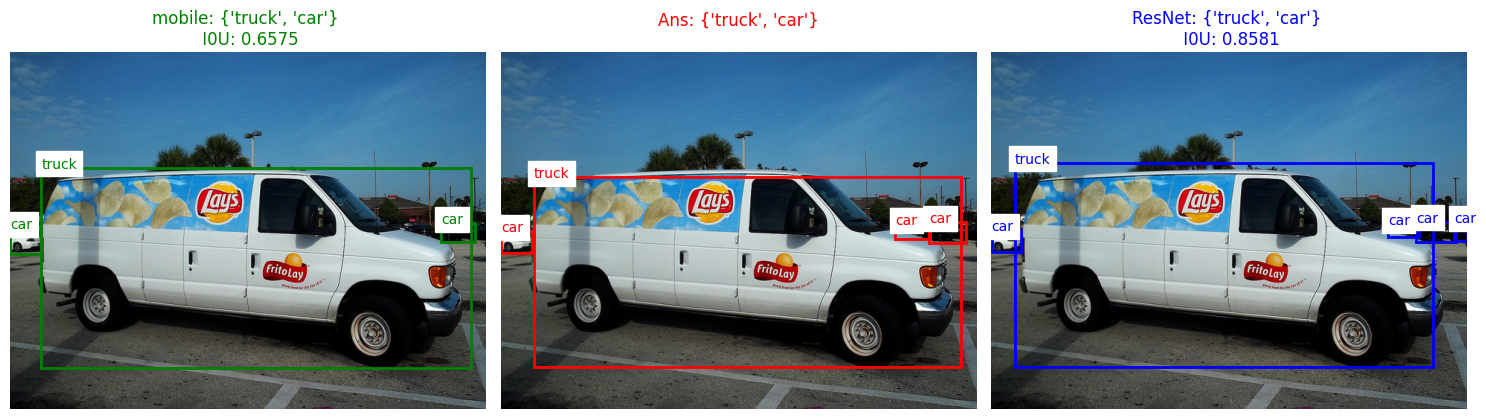

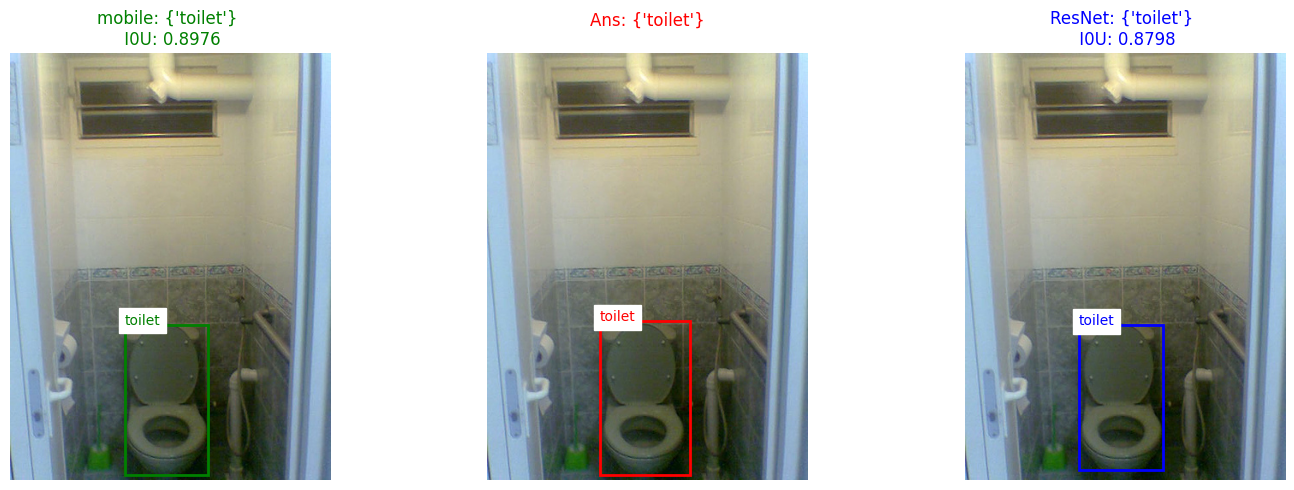

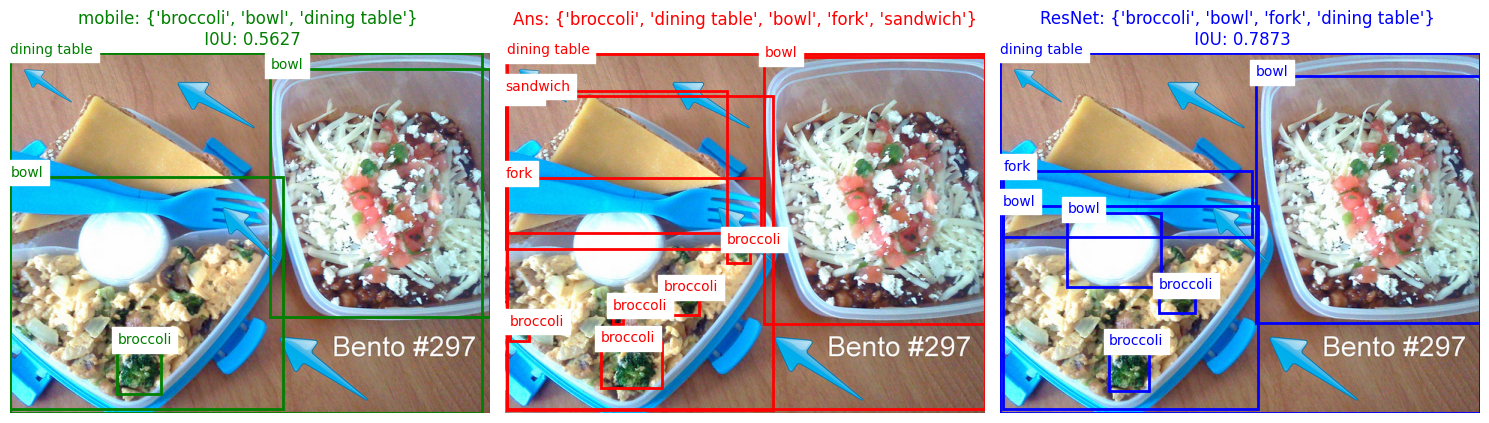

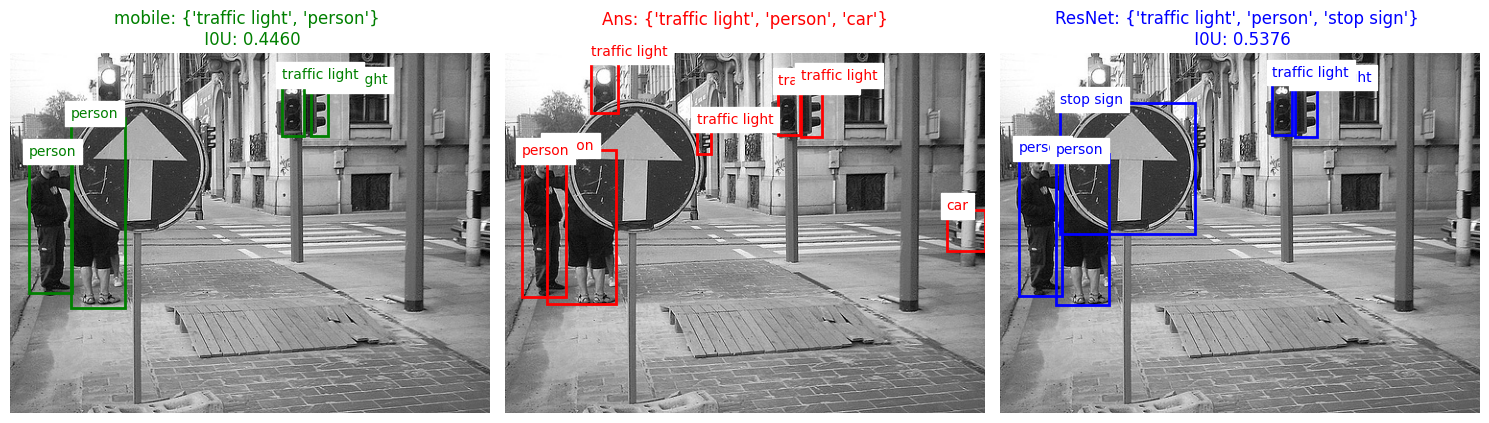

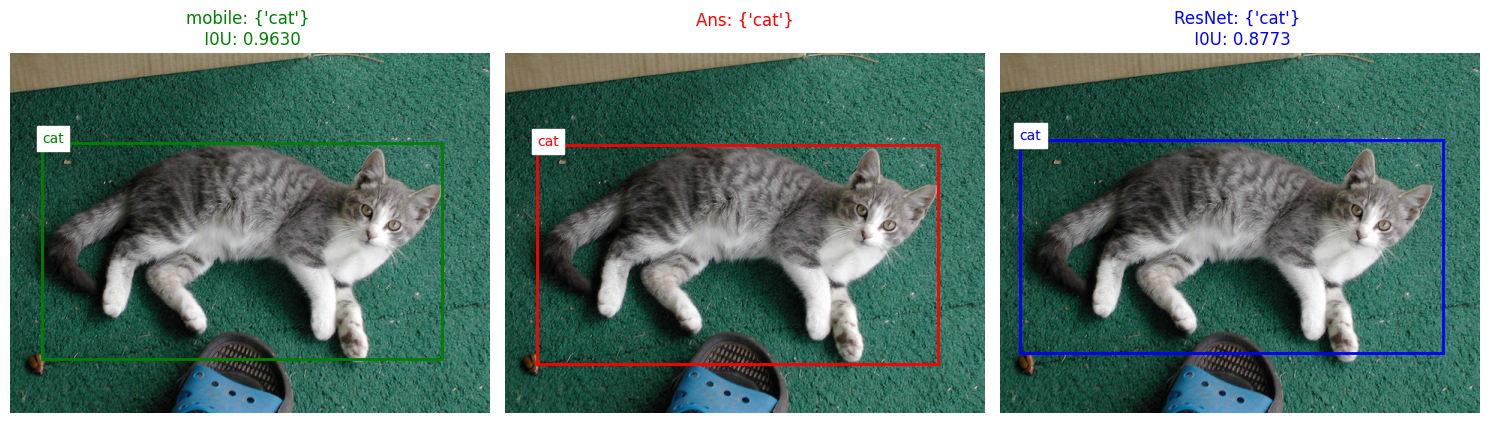

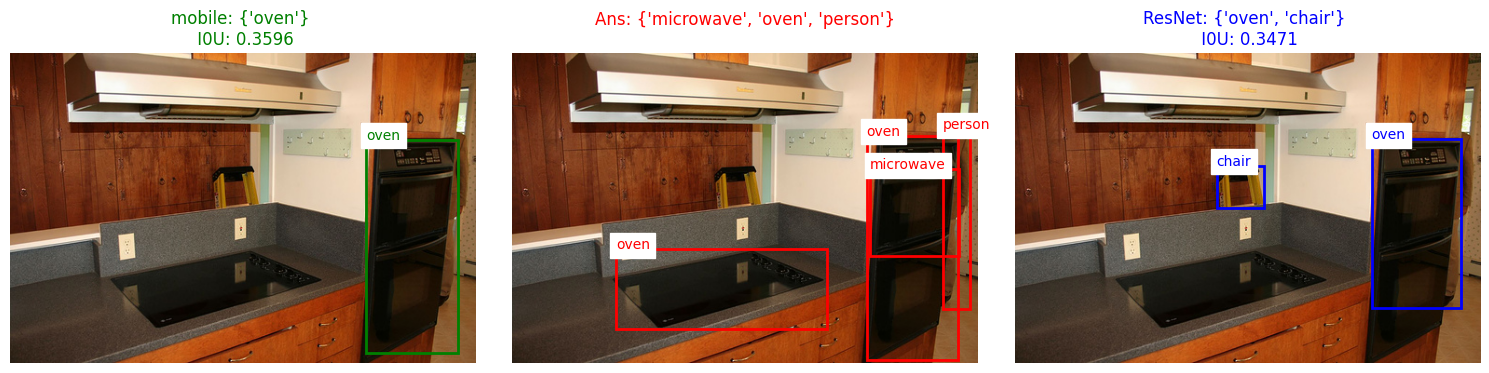

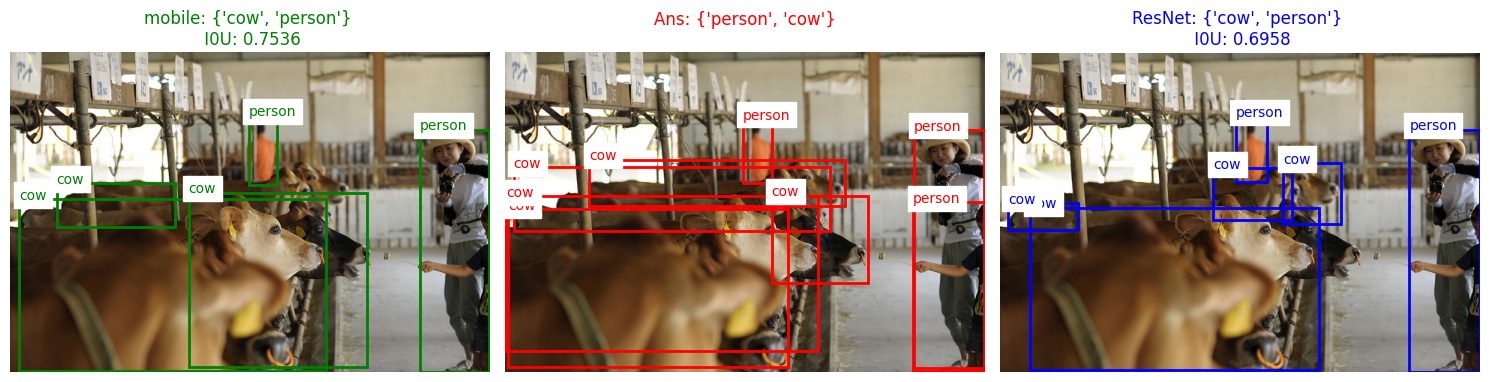

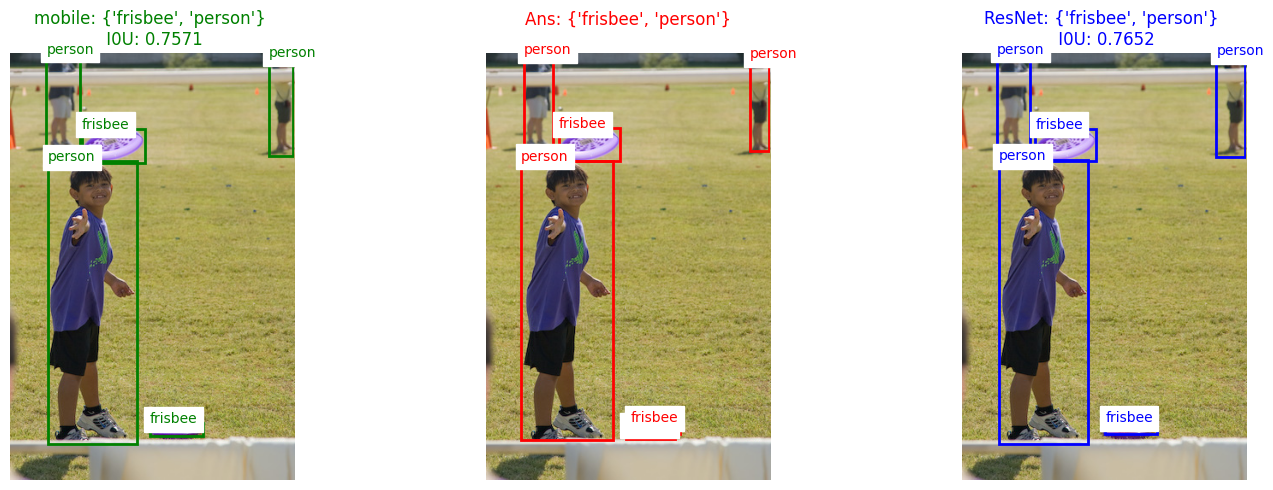

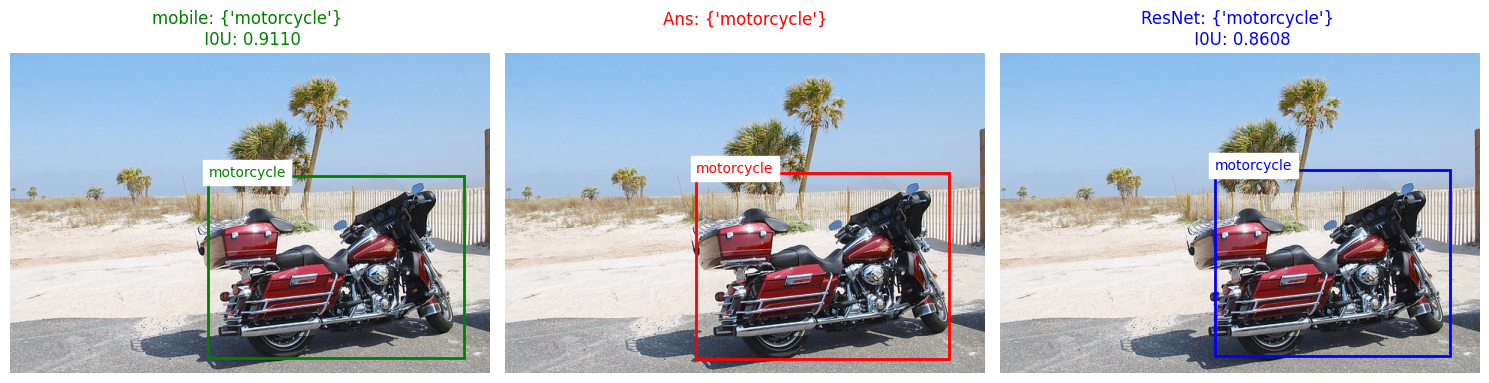

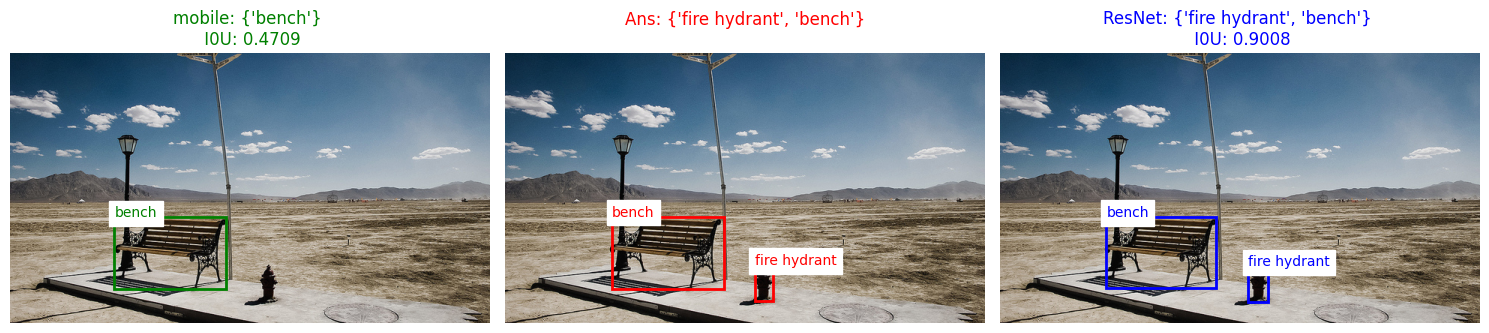

In [74]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_annotated_results(imgId, valid_boxes, model_name, color='g', ax=None):
    # for showing the labels in images
    all_labels = set()

    # Load the image
    imgInfo = coco.loadImgs(imgId)[0]
    image_path = os.path.join(cocoRoot, dataType, imgInfo['file_name'])
    image = Image.open(image_path)

    # calculate IoU
    annIds = coco.getAnnIds(imgIds=imgInfo['id'])
    anns = coco.loadAnns(annIds)
    bbox_tlist_anns = torch.tensor([ann["bbox"] for ann in anns])
    # x,y,w,h -> x1,y1,x2,y2 = x,y,x+w,y+h
    bbox_tlist_anns[:, 2] = bbox_tlist_anns[:, 0] + bbox_tlist_anns[:, 2]
    bbox_tlist_anns[:, 3] = bbox_tlist_anns[:, 1] + bbox_tlist_anns[:, 3]
    
    bbox_tlist_model = torch.stack([box for box, _, _ in valid_boxes])
    iou = torchvision.ops.box_iou(bbox_tlist_anns, bbox_tlist_model)
    avg_iou = np.mean([t.cpu().detach().numpy().sum() for t in iou])
    
    # Iterate through the valid boxes and annotations
    for boxes in valid_boxes:
        box, label, score = boxes
        label = coco.loadCats(label.item())[0]["name"]
        all_labels.add(label)
        x, y, w, h = box.detach().numpy()
        rect = Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor=color, facecolor='none')

        if ax is None:
            plt.gca().add_patch(rect) 
            plt.text(x, y, f'{label}', fontsize=10, color=color, backgroundcolor='w')
        else:
            ax.add_patch(rect)
            ax.text(x, y, f'{label}', fontsize=10, color=color, backgroundcolor='w')

    if ax is None:
        plt.axis('off')
        plt.title(f'{model_name}: {all_labels} \n IoU: {avg_iou:.4f}', color=color)
        plt.imshow(image)
        plt.show()

    else:
        ax.axis('off')
        ax.set_title(f'{model_name}: {all_labels} \n I0U: {avg_iou:.4f}', color=color)
        ax.imshow(image)
    
    return avg_iou



res_iou = []
mobile_iou = []

for i in range(len(valid_ids)):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))    
    plot_image_with_annotations(coco, cocoRoot, dataType, valid_ids[i], ax=axs[1])
    mobile_iou.append(display_annotated_results(valid_ids[i], valid_boxes_mobile[i], "mobile", color='g', ax=axs[0]))
    res_iou.append(display_annotated_results(valid_ids[i], valid_boxes_res[i], "ResNet", color='b', ax=axs[2]))
    plt.tight_layout()

# print the mean of IoU list 
print("ResNet: Avg.", np.mean(res_iou), "; each IoU:", res_iou)
print("MobileNet: Avg.", np.mean(mobile_iou), "; each IoU:", mobile_iou)
